In [1]:
from fastai.tabular.all import *

# Load the csv
df = pd.read_csv('./date_hood_thefts_filled.csv',
                 names=["date", "hood_id", "thefts"])
df.head()


/Users/pika/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


date  hood_id  thefts
0  2015-01-01        0       0
1  2015-01-01        1       0
2  2015-01-01        2       0
3  2015-01-01        3       0
4  2015-01-01        4       0

In [2]:
# Drop hood_id and group by date and sum thefts
df = df.drop(columns=['hood_id'])
df = df.groupby('date').sum()
df.head()

thefts
date              
2015-01-01       0
2015-01-02      31
2015-01-03      17
2015-01-04      23
2015-01-05      22

<AxesSubplot: xlabel='date'>

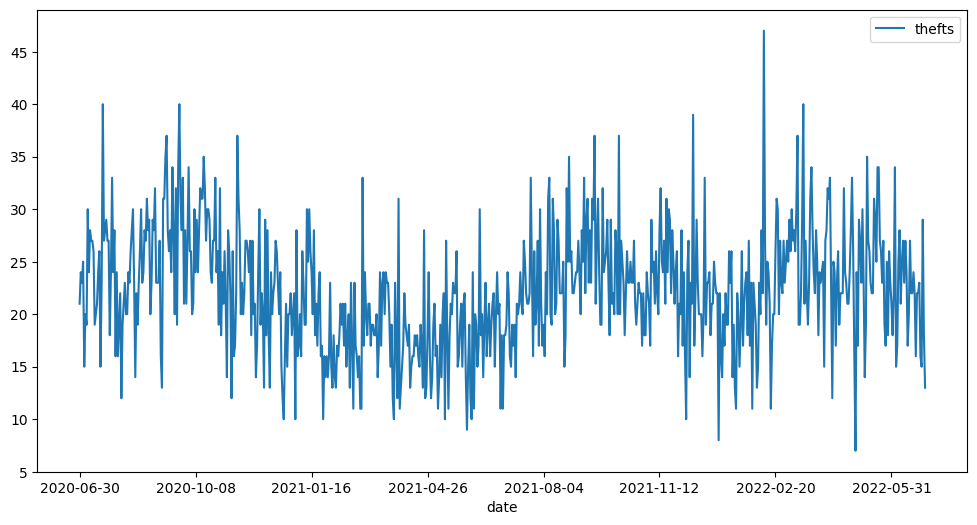

In [3]:
# Plot thefts by the last 2 years
df[-730:].plot(figsize=(12, 6))


<AxesSubplot: xlabel='date'>

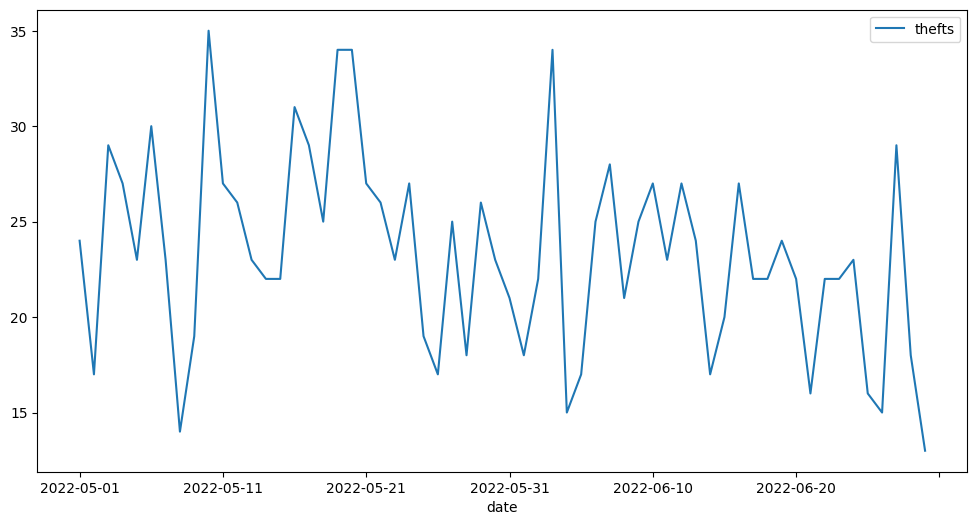

In [4]:
# Plot thefts by the last 2 months
df[-60:].plot(figsize=(12, 6))

In [5]:
# Get the last date in the dataset
from datetime import datetime


last_date = df.index[-1]
# Convert the last date to a datetime object

last_date = datetime.strptime(last_date, '%Y-%m-%d')
last_date

datetime.datetime(2022, 6, 29, 0, 0)

In [6]:
from datetime import timedelta

# Create a dataframe for predictions
df_predictions = pd.DataFrame()

# Loop through the previous 150 days starting from the last date
for i in range(1, 70):
  # Create a new date
  new_date = last_date - timedelta(days=i)
  # Loop from 0 to 158
  for hood_id in range(0, 159):
    # Add the new date and hood_id to the dataframe
    df_predictions = df_predictions.append({'date': new_date, 'hood_id': hood_id}, ignore_index=True)

df_predictions.head()

/var/folders/7b/0z013d0x38n5dm8l78sg1z_m0000gn/T/ipykernel_41265/3331166947.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append({'date': new_date, 'hood_id': hood_id}, ignore_index=True)
/var/folders/7b/0z013d0x38n5dm8l78sg1z_m0000gn/T/ipykernel_41265/3331166947.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append({'date': new_date, 'hood_id': hood_id}, ignore_index=True)
/var/folders/7b/0z013d0x38n5dm8l78sg1z_m0000gn/T/ipykernel_41265/3331166947.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append({'date': new_date, 'hood_id': hood_id}, ignore_index=True)
/var/folders/7b/0z013d0x38n5dm8l78sg1z_m0000gn/T/ipy

date  hood_id
0 2022-06-28        0
1 2022-06-28        1
2 2022-06-28        2
3 2022-06-28        3
4 2022-06-28        4

In [7]:
# Transform the date column to a datetime object
make_date(df_predictions, 'date')
df_predictions.head()


date  hood_id
0 2022-06-28        0
1 2022-06-28        1
2 2022-06-28        2
3 2022-06-28        3
4 2022-06-28        4

In [8]:
# Feature engineer the date column
add_datepart(df_predictions, 'date', drop=False)
df_predictions.head()


date  hood_id  Year  Month  Week  Day  Dayofweek  Dayofyear  \
0 2022-06-28        0  2022      6    26   28          1        179   
1 2022-06-28        1  2022      6    26   28          1        179   
2 2022-06-28        2  2022      6    26   28          1        179   
3 2022-06-28        3  2022      6    26   28          1        179   
4 2022-06-28        4  2022      6    26   28          1        179   

   Is_month_end  Is_month_start  Is_quarter_end  Is_quarter_start  \
0         False           False           False             False   
1         False           False           False             False   
2         False           False           False             False   
3         False           False           False             False   
4         False           False           False             False   

   Is_year_end  Is_year_start       Elapsed  
0        False          False  1.656374e+09  
1        False          False  1.656374e+09  
2        False          False  1.656374e+09  
3        False          False  1.656374e+09  
4        False          False  1.656374e+09

In [9]:
# Load the exported model
learn = load_learner('./exported_models/74_fill_imbalance.pkl')

In [10]:
# Get the predictions
row, clas, probs = learn.predict(df_predictions.iloc[10])
row, clas, probs


(   hood_id  Month  Week   Day  Dayofweek  Dayofyear  Is_month_end  \
 0     11.0    6.0  26.0  28.0        2.0      179.0           1.0   
 
    Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  \
 0             1.0             1.0               1.0          1.0   
 
    Is_year_start      Year  thefts  
 0            1.0  2.622102     0.0  ,
 tensor(0),
 tensor([6.4537e-01, 3.3930e-01, 1.3526e-02, 1.2308e-03, 5.0983e-04, 6.5913e-05]))

In [11]:
# Create new dataframe for predictions
predictions_new = []

# Loop through the predictions and add the predictions to the dataframe
for i in range(0, len(df_predictions)):
  with learn.no_bar(), learn.no_logging():
    row, clas, probs = learn.predict(df_predictions.iloc[i])
  predictions_new.append(int(clas))

In [12]:
# Merge predictions array with the dataframe and rename the column to thefts
df_predictions['thefts'] = predictions_new

df_predictions.head()


date  hood_id  Year  Month  Week  Day  Dayofweek  Dayofyear  \
0 2022-06-28        0  2022      6    26   28          1        179   
1 2022-06-28        1  2022      6    26   28          1        179   
2 2022-06-28        2  2022      6    26   28          1        179   
3 2022-06-28        3  2022      6    26   28          1        179   
4 2022-06-28        4  2022      6    26   28          1        179   

   Is_month_end  Is_month_start  Is_quarter_end  Is_quarter_start  \
0         False           False           False             False   
1         False           False           False             False   
2         False           False           False             False   
3         False           False           False             False   
4         False           False           False             False   

   Is_year_end  Is_year_start       Elapsed  thefts  
0        False          False  1.656374e+09       0  
1        False          False  1.656374e+09       1  
2        False          False  1.656374e+09       0  
3        False          False  1.656374e+09       0  
4        False          False  1.656374e+09       0

In [13]:
# Drop all columns except pred_thefts and Elapsed
df_predictions = df_predictions.drop(columns=['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
                                     'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'hood_id', 'Elapsed'])

# Group by date and sum the thefts
df_predictions = df_predictions.groupby('date').sum()

In [14]:
df_predictions.head()

thefts
date              
2022-01-31      22
2022-02-01      22
2022-02-02      18
2022-02-03      15
2022-02-04      22

<AxesSubplot: xlabel='date'>

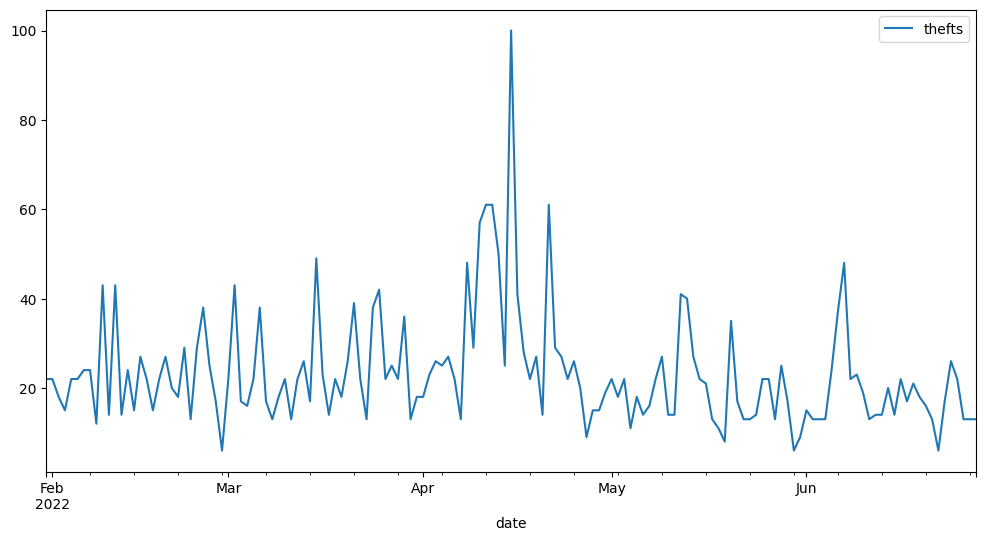

In [15]:
# Plot the predictions
df_predictions.plot(figsize=(12, 6))

In [16]:
# Convert date column to a datetime object
df_predictions.index = pd.to_datetime(df_predictions.index)
df.index = pd.to_datetime(df.index)


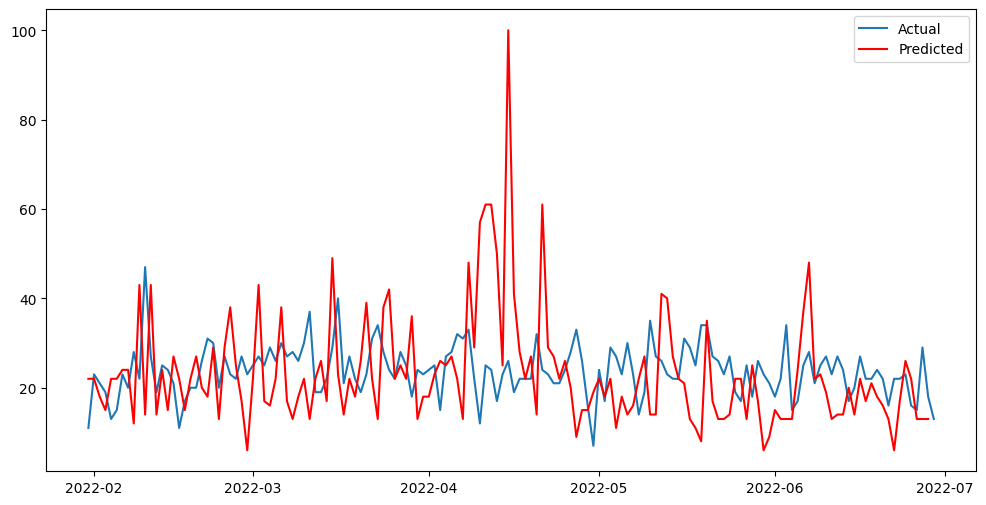

In [17]:
# Use matplotlib to plot df and df_predictions on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df[-70:], label='Actual')
plt.plot(df_predictions, label='Predicted', color='red')
plt.legend()
plt.show()

In [18]:
# Save the predictions to a csv
df_predictions.to_csv('./next_year_predictions.csv')